# Dask

## Why Dask ? 

Python is the domain language of Data science, Data analytics and general programming.

The working horses of these domains are Numpy, Pandas and Sklearn. Those libraries were designed with the focus on small to medium size data projects on a single machine. A prominent example is Pandas, where every execution is done on a single core. 

Dask was developed to scale these packages and the surrounding ecosystem. It works with the existing Python ecosystem to scale it to multi-core machines and distributed clusters.

## Best practice 

#### Don't use a hammer for all the tasks! Start small!

[The full description can be found here](https://docs.dask.org/en/latest/best-practices.html)

Parallelism brings extra complexity and overhead. Sometimes it’s necessary for larger problems, __but often it’s not.__ Before adding a parallel computing system like Dask to your workload you may want to first try some alternatives:

* __Use better algorithms or data structures:__ NumPy, Pandas, Scikit-Learn may have faster functions for what you’re trying to do. It may be worth consulting with an expert or reading through their docs again to find a better pre-built algorithm.

 * __Better file formats:__ Efficient binary formats that support random access can often help you manage larger-than-memory datasets efficiently and simply. See the [Store Data Efficiently](https://docs.dask.org/en/latest/best-practices.html#store-data-efficiently) section.

* __Compiled code:__ Compiling your Python code with Numba or Cython might make parallelism unnecessary. Or you might use the multi-core parallelism available within those libraries.

* __Sampling:__ Even if you have a lot of data, there might not be much advantage from using all of it. By sampling intelligently you might be able to derive the same insight from a much more manageable subset.

* __Profile:__ If you’re trying to speed up slow code it’s important that you first understand why it is slow. Modest time investments in profiling your code can help you to identify what is slowing you down. This information can help you make better decisions about if parallelism is likely to help, or if other approaches are likely to be more effective.


#### Use The Dashboard

Dask comes with a Dashboard to understand if and what is going on. This is important to find and efficient solution. For this reason bokeh needs to be installed additionally. 

[Dask Dashboard explained](https://docs.dask.org/en/latest/diagnostics-distributed.html)

#### Avoid Very Large Partitions¶

Your chunks of data should be small enough so that many of them fit in a worker’s available memory at once. You often control this when you select partition size in Dask DataFrame or chunk size in Dask Array.

Dask will likely manipulate as many chunks in parallel on one machine as you have cores on that machine. So if you have 1 GB chunks and ten cores, then Dask is likely to use at least 10 GB of memory. Additionally, it’s common for Dask to have 2-3 times as many chunks available to work on so that it always has something to work on.

If you have a machine with 100 GB and 10 cores, then you might want to choose chunks in the 1GB range. You have space for ten chunks per core which gives Dask a healthy margin, without having tasks that are too small


### Stop Using Dask When No Longer Needed¶

In many workloads it is common to use Dask to read in a large amount of data, reduce it down, and then iterate on a much smaller amount of data. 
For this latter stage on smaller data it may make sense to stop using Dask, and start using normal Python again.

```{Pyton}
df = dd.read_parquet("lots-of-data-*.parquet")
df = df.groupby('name').mean()  # reduce data significantly
df = df.compute() ## continue on with Pandas/NumPy
```

For more in depth best practice go check out [https://docs.dask.org/en/latest/best-practices.html](https://docs.dask.org/en/latest/best-practices.html)

### Library Import

In [2]:
### install dask in your venv
#!pip install dask

###install bokeh for visualisation of the dask server
#!pip install bokeh

Install the nessesary libraries

In [23]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz 

###Dask import
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=4, memory_limit='1GB')
client

import pyarrow as pa


import warnings
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

warnings.filterwarnings('ignore')

from tqdm import tqdm

## Description of what is going on

Installing [dask (doc)](https://dask.org/) and [bokeh (doc)](https://bokeh.org/).  

Dask : Dask is an open source library for parallel computing written in Python.
Dask is a library composed of two parts. 
It includes a task scheduling component for building dependency graphs and scheduling tasks. Second, it includes the distributed data structures with APIs similar to Pandas Dataframes or NumPy arrays. Dask has a variety of use cases and can be run with a single node and scale to thousand node clusters. (Source: [Wiki](https://en.wikipedia.org/wiki/Dask_(software)))

Bokeh : Bokeh is a Python library for creating interactive visualizations for modern web browsers. It helps you build beautiful graphics, ranging from simple plots to complex dashboards with streaming datasets. With Bokeh, you can create JavaScript-powered visualizations without writing any JavaScript yourself. (Source : [bokeh Doc](https://docs.bokeh.org/en/latest/))

__Bokeh ist just importet for an dashboard of what is happening with your Dask Server__


### Optional hint
 If you want to know, what your mac is doing I would recomment you to install [__htop__](https://htop.dev/)

this could be done by 
```
brew install htop
```

and with the terminal command  ```htop``` you will get an (customizable) overview on what is going on under the hood of your unix machine. 
This is an extension to the classical ```top```  command. 


### Talking about the imports

#### Dask array (dask numpy)

```{python}
import dask.array as da
```

_Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs._ Source:[dask array doc](https://docs.dask.org/en/stable/array.html)

Dask arrays coordinate many NumPy arrays (or “duck arrays” that are sufficiently NumPy-like in API such as CuPy or Sparse arrays) arranged into a grid. These arrays may live on disk or on other machines.
They are build up the following: 

![](./NB-images/dask-array.svg)


__Examples can be found [here](https://examples.dask.org/array.html)__

#### Dask bag (not used here but mentioned)

```{python}
import dask.bag as db
```

Dask Bag implements operations like ```map```, ```filter````, ````fold````, and ```groupby```` on collections of generic Python objects. It does this in parallel with a small memory footprint using Python iterators. It is similar to a parallel version of [PyToolz](https://toolz.readthedocs.io/en/latest/) or a Pythonic version of the [PySpark RDD](https://spark.apache.org/docs/latest/api/python/).

Dask bags are often used to parallelize simple computations on unstructured or semi-structured data like text data, log files, JSON records, or user defined Python objects.


Examples can be found [here](https://examples.dask.org/bag.html )

#### Dask Dataframe (dask pandas)

```{python}
import dask.dataframe as dd
```

Import  dask dataframe.

_A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames._ Source: [dask datafram docu](https://docs.dask.org/en/stable/dataframe.html)

Dask Dataframes coordinate many Pandas dataframes, partitioned along an index. They support a large subset of the Pandas API.
Shown as an example here :

![](./NB-images/dask-dataframe.svg)

So your huge file gets split in to several smaller. 
More in the later part at [importing](#importing-data)

Additional, have a look at the video [Dask Dataframe: Introduction](https://youtu.be/AT2XtFehFSQ)

__Example can be found [here](https://examples.dask.org/dataframe.html)__

#### Dask Distributed

````{Python}
from dask.distributed import Client, progress
````

Imports dask distributed.

 This is the main sublibrary for the distribution.
 
_Dask.distributed is a lightweight library for distributed computing in Python. It extends both the concurrent.futures and dask APIs to moderate sized clusters._ -Source:  [Dask distrubuted doc](https://distributed.dask.org/en/stable/)


With distributed you have to tell the server what you want to do.
 So a [Client](https://distributed.dask.org/en/stable/client.html) is set up.The Client is the primary entry point for users of dask.distributed. 
Even if the distribution is also working without setting up a clinet on your local machine, the people of Dask recomment to set one up. 

 _"We recommend using dask.distributed clusters at all scales for the following reasons:"_

 _1. It provides access to asynchronous API, notably Futures_

_2. It provides a diagnostic dashboard that can provide valuable insight on performance and progress_

_3.  It handles data locality with sophistication, and so can be more efficient than the multiprocessing scheduler on workloads that require multiple processes_

Setting up a client [beginners-config](https://blog.dask.org/2020/07/30/beginners-config)

```{Python}
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
client
```

So up for creating a client: 
 
_If you create a client without providing an address it will start up a local scheduler and worker for you._ 

* n_workers defines the number of used cores
    * Before you decide how many workers to use, try using the default. In many cases dask can choose a default that makes use of the size and shape of your machine. If that doesn’t work, then you’ll need some information about the size and shape of your work. In particular you’ll want to know:

        1) What size is your computer or what types of compute nodes do you have access to?
        2) How big is your data?
         3) What is the structure of the computation that you are trying to do?

* threads_per_worker Number of threads per each core

* memory_limit = Bytes of memory per process that the worker can use. This can be: - an integer (bytes), note 0 is a special case for no memory management. - a float (fraction of total system memory). - a string (like 5GB or 5000M). - ‘auto’ for automatically computing the memory limit. (keep it to your machine size 8GB) 

if you set nothing else, the ```client``` will give the adresse for the dashboard. 

If your season hasn't ended you can restart your client bei ```client.restart```

Additional have a look at [Dask Setup: Introduction](https://www.youtube.com/watch?v=TQM9zIBzNBo)

## Hands-on 

In [10]:
client

<bound method Client.restart of <Client: 'tcp://127.0.0.1:51430' processes=4 threads=16, memory=3.73 GiB>>

Get the Dashboard adresse for your "sever"

### Importing data with pandas

[magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

In [11]:
%%time # magic command 

articles = pd.read_csv("../data/articles.csv").sort_values ("article_id").reset_index(drop=True)
custom = pd.read_csv("../data/customers.csv").sort_values("customer_id").reset_index(drop=True)
trans= pd.read_csv("../data/transactions_train.csv").sort_values("customer_id").reset_index(drop=True)
sample=pd.read_csv("../data/sample_submission.csv").sort_values("customer_id").reset_index(drop=True)

CPU times: user 1min 11s, sys: 12.2 s, total: 1min 23s
Wall time: 1min 23s


## Importing data

In [12]:
%%time

articles_dd =dd.read_csv("../data/articles.csv" , blocksize=24000000).sort_values ("article_id").reset_index(drop=True)
custom_dd = dd.read_csv("../data/customers.csv",blocksize=24000000).sort_values("customer_id").reset_index(drop=True)
tran_dds= dd.read_csv("../data/transactions_train.csv", blocksize=24000000).sort_values("customer_id").reset_index(drop=True)
sample_dd=dd.read_csv("../data/sample_submission.csv", blocksize=24000000).sort_values("customer_id").reset_index(drop=True)

CPU times: user 4.18 s, sys: 760 ms, total: 4.94 s
Wall time: 27.5 s


### comparison with pandas

In [14]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [15]:
articles_dd.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [31]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [35]:
articles_dd.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


To see what is going on, ```visualize```might be helpful. 

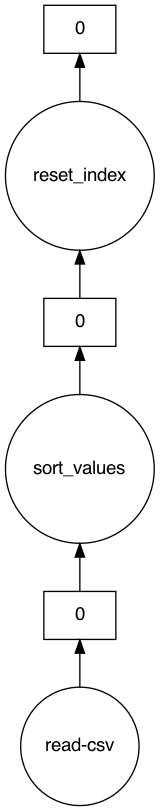

In [28]:
articles_dd.visualize()

### Describe

In [17]:
%time
articles.describe().T

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


,count,mean,std,min,25%,50%,75%,max
article_id,105542.0,6.984246e+08,1.284624e+08,108775015.0,616992501.0,702213001.5,7.967030e+08,959461001.0
product_code,105542.0,6.984246e+05,1.284624e+05,108775.0,616992.5,702213.0,7.967030e+05,959461.0
product_type_no,105542.0,2.348619e+02,7.504931e+01,-1.0,252.0,259.0,2.720000e+02,762.0
graphical_appearance_no,105542.0,1.009515e+06,2.241359e+04,-1.0,1010008.0,1010016.0,1.010016e+06,1010029.0
colour_group_code,105542.0,3.223382e+01,2.808615e+01,-1.0,9.0,14.0,5.200000e+01,93.0
perceived_colour_value_id,105542.0,3.206183e+00,1.563839e+00,-1.0,2.0,4.0,4.000000e+00,7.0
perceived_colour_master_id,105542.0,7.807972e+00,5.376727e+00,-1.0,4.0,5.0,1.100000e+01,20.0
department_no,105542.0,4.532778e+03,2.712692e+03,1201.0,1676.0,4222.0,7.389000e+03,9989.0
index_group_no,105542.0,3.171534e+00,4.353234e+00,1.0,1.0,2.0,4.000000e+00,26.0
section_no,105542.0,4.266422e+01,2.326010e+01,2.0,20.0,46.0,6.100000e+01,97.0


In [19]:
%time
articles_dd.describe()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
npartitions=1,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...


This will not work, because Dask is working in lazy execution. [Lazy execution](https://tutorial.dask.org/01x_lazy.html)
This means the final result is given on demand.

To bring Dask for an execution you need to add ```.compute()```

In [21]:
%time
articles_dd.compute().describe().T

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


,count,mean,std,min,25%,50%,75%,max
article_id,105542.0,6.984246e+08,1.284624e+08,108775015.0,616992501.0,702213001.5,7.967030e+08,959461001.0
product_code,105542.0,6.984246e+05,1.284624e+05,108775.0,616992.5,702213.0,7.967030e+05,959461.0
product_type_no,105542.0,2.348619e+02,7.504931e+01,-1.0,252.0,259.0,2.720000e+02,762.0
graphical_appearance_no,105542.0,1.009515e+06,2.241359e+04,-1.0,1010008.0,1010016.0,1.010016e+06,1010029.0
colour_group_code,105542.0,3.223382e+01,2.808615e+01,-1.0,9.0,14.0,5.200000e+01,93.0
perceived_colour_value_id,105542.0,3.206183e+00,1.563839e+00,-1.0,2.0,4.0,4.000000e+00,7.0
perceived_colour_master_id,105542.0,7.807972e+00,5.376727e+00,-1.0,4.0,5.0,1.100000e+01,20.0
department_no,105542.0,4.532778e+03,2.712692e+03,1201.0,1676.0,4222.0,7.389000e+03,9989.0
index_group_no,105542.0,3.171534e+00,4.353234e+00,1.0,1.0,2.0,4.000000e+00,26.0
section_no,105542.0,4.266422e+01,2.326010e+01,2.0,20.0,46.0,6.100000e+01,97.0


In [29]:
articles.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [30]:
articles_dd.compute().info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

## Store the data in a binary file know as parquet

[parquet](https://parquet.apache.org/)

Apache Parquet is an open source, column-oriented data file format designed for efficient data storage and retrieval. It provides efficient data compression and encoding schemes with enhanced performance to handle complex data in bulk. Parquet is available in multiple languages including Java, C++, Python, etc...

In [37]:
articles_dd_1 = dd.read_parquet("../parquet/articles.parquet")

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
##articles_dd.to_parquet("../parquet")